In [1]:
# Linear SVM, CSAR trining, Docking Scores, Pisani Residues

In [2]:
import pandas as pd
import numpy as np
import glob, os, sys
sys.path.append('..')

In [3]:
from modules.plotting_metrics import PlotMetric
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
# Helper function
%run ./helper_functions_S6.ipynb

In [5]:
# Loading the data:
data_dir = '../data/docking_scores/'
# vinardo Docking Scores (dksc) CSAR
X_dksc_CSAR, y_dksc_CSAR = \
open_results(path = F'{data_dir}/vs_docking_crys_ensemble_VINARDO.csv', 
             column_to_drop = 'ActiveInactive')
# Vinardo Docking Scores (dksc) CSAR
X_dksc_DUD, y_dksc_DUD = \
open_results(path = F'{data_dir}/vs_docking_DUD2006_vs_402_crys_vinardo_8x.csv',
             column_to_drop = 'Actividad')
# Vianrdo Docking Scores (dksc) DEKOIS2
X_dksc_DEKOIS, y_dksc_DEKOIS = \
open_results(path = F'{data_dir}/vs_dk_CRYS_402_DEKOIS_VINARDO_docking_score.csv',
             column_to_drop = 'Actividad')

In [6]:
# Dictionary of docking results (Only DkSc are included)
scores_dic = {'CSAR': {'Dk_sc':   {'X': X_dksc_CSAR, 'y': y_dksc_CSAR}}, 
              'DUD':  {'Dk_sc':   {'X': X_dksc_DUD,  'y': y_dksc_DUD}}, 
              'DEKOIS': {'Dk_sc': {'X': X_dksc_DEKOIS,  'y': y_dksc_DEKOIS}}, 
             }

In [7]:
# Testing with the two following estimators
from sklearn.svm import SVC, LinearSVC

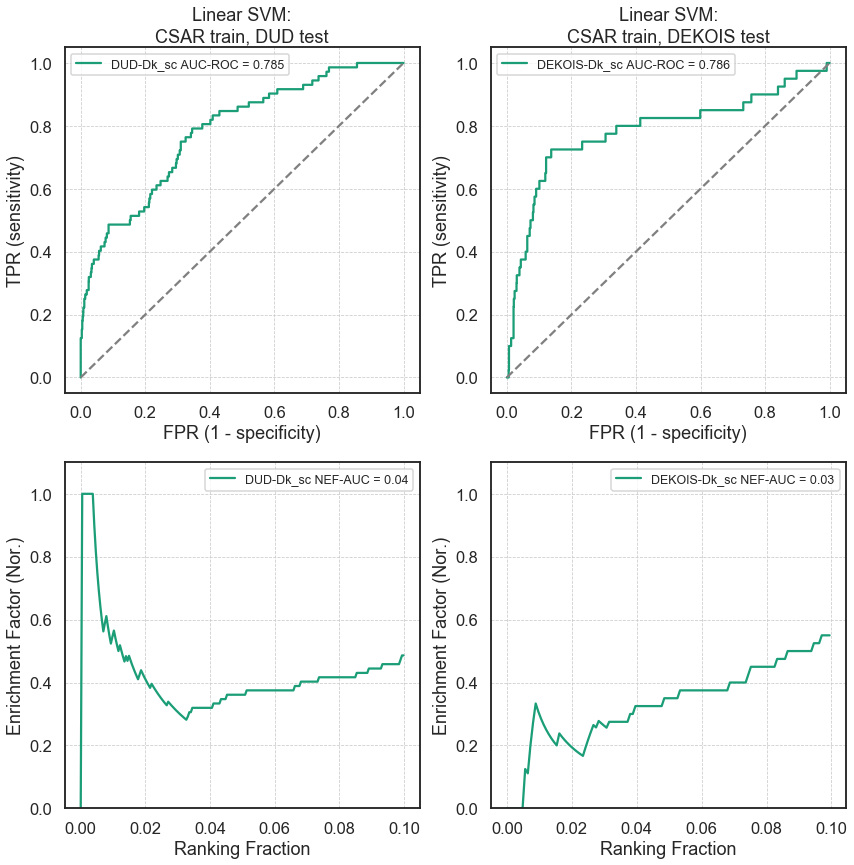

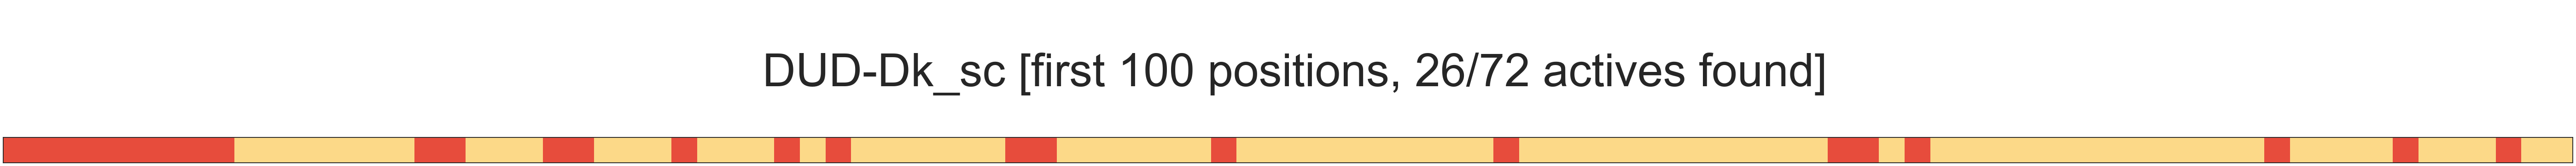

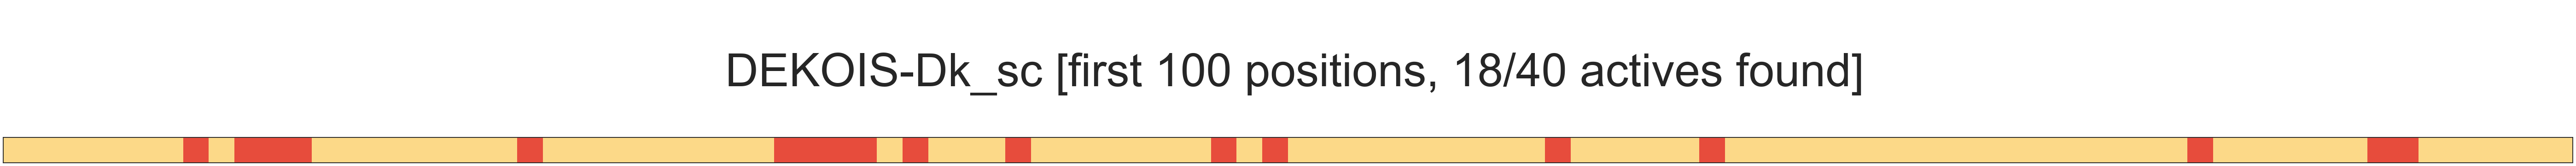

In [8]:
# first with SVC
# The best param found in the  grid search was C = 1
train_key = 'CSAR'
test_keys = ['DUD', 'DEKOIS']
C = 0.1
model = SVC


svm = SVC
svm_lineal = train_wrapper(train_key = train_key, list_of_scores = ['Dk_sc'],
                               scores_dic = scores_dic, estimator = svm,
                               kernel = 'linear', probability = True, C = 0.1 )

svm_lineal_pred = eval_wrapper(trained_model = svm_lineal, 
                            test_keys = test_keys, list_of_scores = ['Dk_sc'], 
                            scores_dic = scores_dic, decreasing = False)

plot_predict_results(title = 'Linear SVM', predictions = svm_lineal_pred, 
                     train_key = train_key, plot_rankings = True, plot_nef = False)


## Random Sampling:
Randomly choose n features for train and test.

In [44]:
# Defining some variables and parameters
score_type = 'Dk_sc'
train_key = 'CSAR'
test_keys = ['DUD', 'DEKOIS']
C = 0.1
model = SVC

N_REPS = 30
MIN_CONFS = 2
MAX_CONFS = 20
INTERVAL = 1

# Then we create the dataframes to store the results
list_of_columns = [F'rep_{i}' for i in range(N_REPS)]

# Two dataframes, one for DUD and one for DEKOIS
df_rdPick_DUD_lsvc = pd.DataFrame(columns = list_of_columns)
df_rdPick_DEKOIS_lsvc = pd.DataFrame(columns = list_of_columns)


# Run the loop
for N_CONFS in range(MIN_CONFS, MAX_CONFS + 1, INTERVAL):
    n_conf_row = random_confs_picking(scores_dic = scores_dic, score_type = score_type,
                             train_key = train_key, test_keys = test_keys,
                             n_features = N_CONFS, n_reps = N_REPS,
                             # Exclusive hyperparameters for the selected model
                             model = model, C = C, kernel = 'linear', probability = True)
    # Add the result to the corresponding row
    df_rdPick_DUD_lsvc.loc[ N_CONFS ] = n_conf_row['DUD']
    df_rdPick_DEKOIS_lsvc.loc[ N_CONFS ] = n_conf_row['DEKOIS']

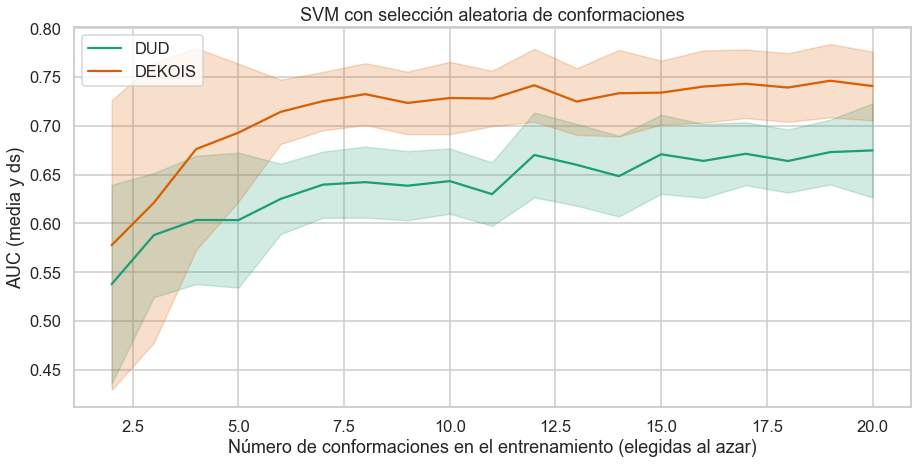

In [47]:
plt.figure(figsize=(15, 7))

sns.set_style("whitegrid")
sns.lineplot(x = 'variable', y = 'value', 
             data = df_rdPick_DUD_lsvc.T.melt(), ci = 'sd', label = 'DUD')
sns.lineplot(x = 'variable', y = 'value', 
             data = df_rdPick_DEKOIS_lsvc.T.melt(), ci = 'sd', label = 'DEKOIS')
plt.xlabel('Número de conformaciones en el entrenamiento (elegidas al azar)')
plt.ylabel('AUC (media y ds)')
plt.title('SVM con selección aleatoria de conformaciones')
plt.show()